# **Behavioral Cloning** 
## Project No3 for 1st. Term of Self-Driving Car Engineer Nanodegree at Udacity

In [1]:
import csv
import numpy as np
from collections import defaultdict
import matplotlib.image as mpimg
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
from PIL import Image

'''Read csv file'''
def read_csvfile (csv_filename):
    csv_data=defaultdict(list)
    freader = csv.reader(open(csv_filename), delimiter=',')
    header = next(freader)
    for row in freader:
        for index in range(len(header)):
            csv_data[header[index]].append(''.join(row[index]).strip() )
    return csv_data

driving_log = read_csvfile('driving_log.csv')
driving_log['steering'] = np.array(driving_log['steering'],dtype=np.float32)
driving_log['throttle'] = np.array(driving_log['throttle'],dtype=np.float32)
driving_log['brake'] = np.array(driving_log['brake'],dtype=np.float32)
driving_log['speed'] = np.array(driving_log['speed'],dtype=np.float32) 

valid_indexes =driving_log['speed']>8 #removing data with no speed

for _key in (list(driving_log.keys())):
    driving_log[_key] =np.array (driving_log[_key])
    driving_log[_key] =driving_log[_key] [valid_indexes]

    
#valid_indexes = driving_log['throttle'] >0.2#removing data with no speed
#for _key in (list(driving_log.keys())):
#    driving_log[_key] =np.array (driving_log[_key])
#    driving_log[_key] =driving_log[_key] [valid_indexes]
    

#valid_indexes = driving_log['throttle'] >0.2#removing data with no speed
#for _key in (list(driving_log.keys())):
#    driving_log[_key] =np.array (driving_log[_key])
#    driving_log[_key] =driving_log[_key] [valid_indexes]
#    
for index in range (len(driving_log['steering'])):
    if driving_log['steering'][index]>1:
        driving_log['steering'][index] = 1
    elif driving_log['steering'][index]<-1:
        driving_log['steering'][index] = -1

print (len(driving_log['center'] ))

column_name =['center','left', 'right']


4586


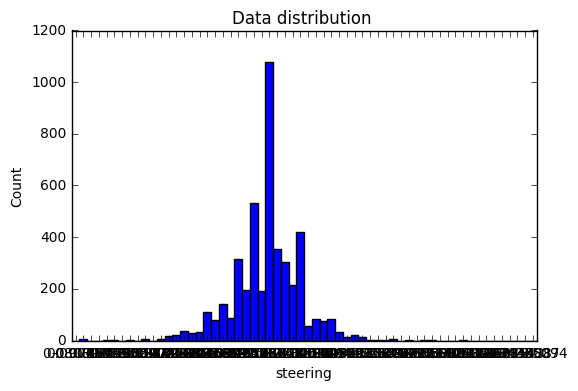

In [2]:
def check_class_distribution(steering,_title):
    class_group =[0]*60
    for item in steering:
        class_group[int((item+1)*25)] += 1 
    width = 1
    objects = set(steering)
    y_pos = np.arange(len(class_group))
    performance = class_group
    plt.bar(y_pos, performance, width) 
    plt.xticks(y_pos +width*0.5,objects)
    plt.ylabel('Count',size=10)
    plt.xlabel('steering')
    plt.title(_title)
    plt.show()

check_class_distribution(driving_log['steering'], 'Data distribution ')

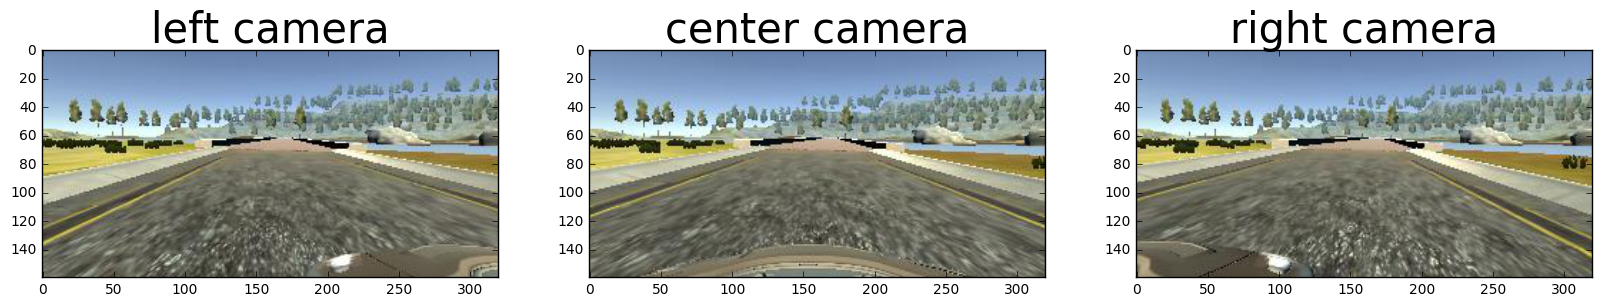

In [3]:
# Visualize images 
im_left =mpimg.imread(driving_log['left'][5])
im_center =mpimg.imread(driving_log['center'][5])
im_right =mpimg.imread(driving_log['right'][5])


f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(im_left)
#ax1.set_title('steering:' + str(driving_log['steering'][5] +0.25), fontsize=30)
ax1.set_title('left camera', fontsize=30)
ax2.imshow(im_center)
#ax2.set_title('steering:' + str(driving_log['steering'][5]), fontsize=30)
ax2.set_title('center camera', fontsize=30)
ax3.imshow(im_right)
#ax3.set_title('steering:' + str(driving_log['steering'][5] -0.25), fontsize=30)
ax3.set_title('right camera', fontsize=30)

steering:  0.176582


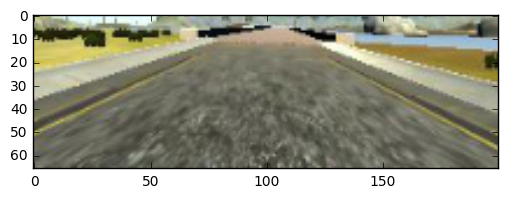

In [4]:


def AOI_image (img, resize_value):
    #Area of interest of the image, it applies crop and resize.
    (h, w) = img.shape[:2]
    y1=int(h*0.35)
    y2=int(h*0.16)
    x=0
    nimg = cv2.resize(img[y1:h-y2, x:x+w],resize_value)
    return nimg

def read_image (data_line, steering_shift, resize_image):
    image_elected_id = np.random.randint(3)
    img = mpimg.imread(data_line[column_name[image_elected_id]] )
    img = AOI_image(img, resize_image)
    if column_name[image_elected_id] == 'center':
        steering = data_line['steering']
    elif column_name[image_elected_id] == 'left':
        steering = data_line['steering'] + steering_shift
        if steering>1:
            steering = 1.0 
    else:
        steering = data_line['steering']  - steering_shift
        if steering<-1:
            steering = -1.0        
    return img , steering

# Visualize images

d_line = {}
d_line['center'] = driving_log['center'][5]
d_line['left'] = driving_log['left'][5]
d_line['right'] = driving_log['right'][5]
d_line['steering'] =  driving_log['steering'][5]

im_center =mpimg.imread(d_line['center'])
im_left =mpimg.imread(d_line['left'])
im_right =mpimg.imread(d_line['right'])

ximage, ysteering = read_image(d_line,0.25,(200,66))
plt.figure()
plt.imshow(ximage)
print("steering: ",ysteering)




-0.313097137894
(66, 200, 3)


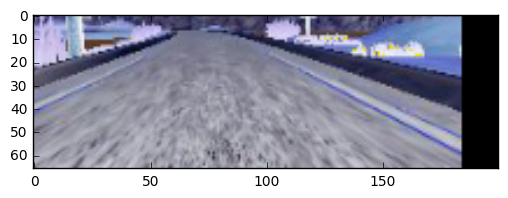

In [5]:
def image_flip(img,steering):
    nimg = cv2.flip(img,1)
    nsteering =  -1* steering
    return nimg,nsteering

def image_traslation (img,steering, x,y):
    (h, w) = img.shape[:2]
    M = np.float32([[1,0,x],[0,1,y]])
    nimg = cv2.warpAffine(img,M,(w,h))
    nsteering = (steering+ (x/125))*(1+y/100)#200
    return nimg,nsteering

def change_brightness(img, brightness_value):  
    # convert to HSV to change the brightness 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * brightness_value
    #Convert to RGB
    nimg = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return nimg

def yuv_scale (img):
    nimg =cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    #nimages = np.asarray(nimages, dtype=np.float32)
    return nimg

def perturb_steering(steering):
    nsteering= steering*(1+np.random.uniform(-1, 1)/50)
    return nsteering
       
     
def preprocess_image(data_line, resize_image):
    img, steering = read_image(data_line, 0.25,resize_image)   
    if np.random.randint(2) == 1:
        img, steering = image_flip(img,steering)
    if np.random.randint(2) == 1:
        img,steering=image_traslation (img,steering, randint(-25,25) ,0)
    if np.random.randint(2) == 1:
        img,steering=image_traslation (img,steering, 0 ,randint(-10,10))
    if np.random.randint(2) == 1:
        img=change_brightness(img, np.random.uniform(0.6, 1.3))
    img =np.asarray(img, dtype=np.float32)
    steering = perturb_steering(steering)
    return img, steering

# Visualize images
d_line = {}
lindex = randint(0,len(driving_log['center']))
d_line['center'] = driving_log['center'][lindex]
d_line['left'] = driving_log['left'][lindex]
d_line['right'] = driving_log['right'][lindex]
d_line['steering'] =  driving_log['steering'][lindex]

ximage, ysteering = preprocess_image(d_line,(200,66))
plt.figure()
plt.imshow(ximage)
print(ysteering)
print (ximage.shape)


In [6]:

def generate_train_batch(img_dictionary, w,h, batch_size = 64):
    batch_images = np.zeros((batch_size, h, w,3))
    batch_steering = np.zeros((batch_size))
    d_line = {}
    while 1:
        index_batch = np.random.choice(len(img_dictionary['steering']), batch_size)
        for index in range(batch_size) :
            d_line['center'] = img_dictionary['center'][index_batch[index]]
            d_line['left'] = img_dictionary['left'][index_batch[index]]
            d_line['right'] = img_dictionary['right'][index_batch[index]]
            d_line['steering'] =  img_dictionary['steering'][index_batch[index]]
            Ximg,ysteering = preprocess_image(d_line, (w,h))
            batch_images[index] =Ximg
            batch_steering[index] =ysteering
        yield batch_images, batch_steering


In [7]:
train_data_generator = generate_train_batch(driving_log, 200,66,256)
validation_data_generator =  generate_train_batch(driving_log, 200,66,256)
from pathlib import Path

def save_model(json_file,weights_file):
    if Path(json_file).is_file():
        os.remove(json_file)
    json_model = model.to_json()
    
    with open(json_file,"w" ) as w_file:
        w_file.write(json_model)
        
    if Path(weights_file).is_file():
        os.remove(weights_file)
    print (json_file + ' and '+weights_file + ' have been saved successfully' )
    model.save_weights(weights_file)

Using TensorFlow backend.


Epoch 1/2
73216/73376 [============================>.] - ETA: 0s - loss: 0.0479

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


73472/73376 [==============================] - 180s - loss: 0.0479 - val_loss: 0.0396
Epoch 2/2
73472/73376 [==============================] - 161s - loss: 0.0424 - val_loss: 0.0369


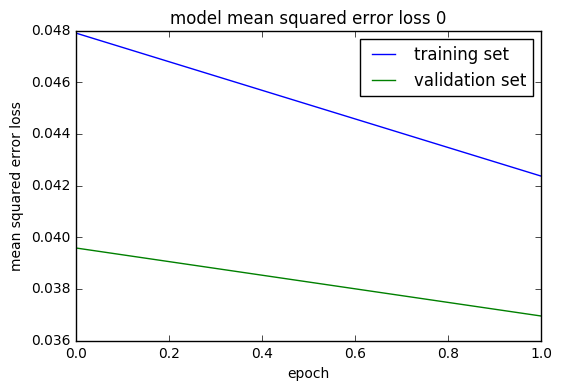

model_0.json and model_0.h5 have been saved successfully
Epoch 1/2
73472/73376 [==============================] - 165s - loss: 0.0412 - val_loss: 0.0379
Epoch 2/2
73472/73376 [==============================] - 159s - loss: 0.0402 - val_loss: 0.0368


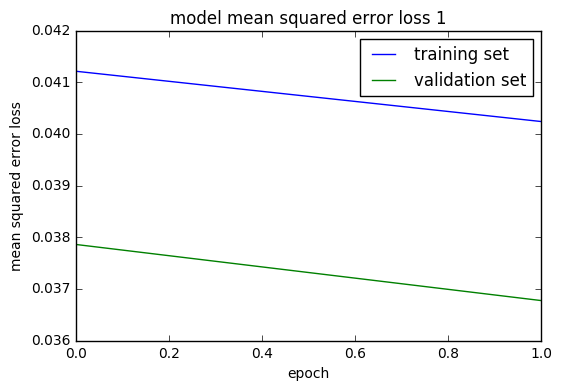

model_1.json and model_1.h5 have been saved successfully
Epoch 1/2
73472/73376 [==============================] - 164s - loss: 0.0392 - val_loss: 0.0353
Epoch 2/2
73472/73376 [==============================] - 159s - loss: 0.0382 - val_loss: 0.0343


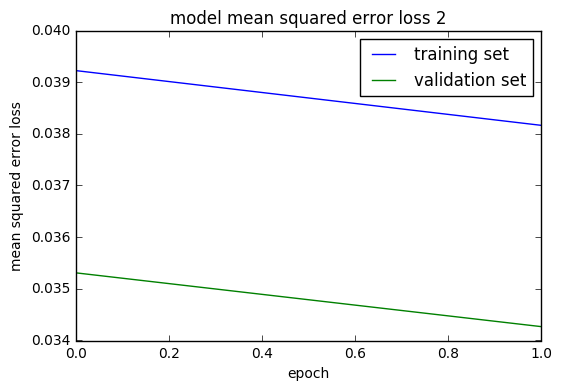

model_2.json and model_2.h5 have been saved successfully
Epoch 1/2
73472/73376 [==============================] - 164s - loss: 0.0377 - val_loss: 0.0336
Epoch 2/2
73472/73376 [==============================] - 159s - loss: 0.0367 - val_loss: 0.0322


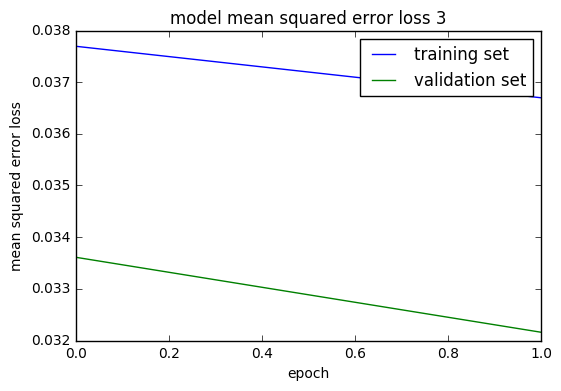

model_3.json and model_3.h5 have been saved successfully
Epoch 1/2
73472/73376 [==============================] - 163s - loss: 0.0358 - val_loss: 0.0322
Epoch 2/2
73472/73376 [==============================] - 160s - loss: 0.0361 - val_loss: 0.0311


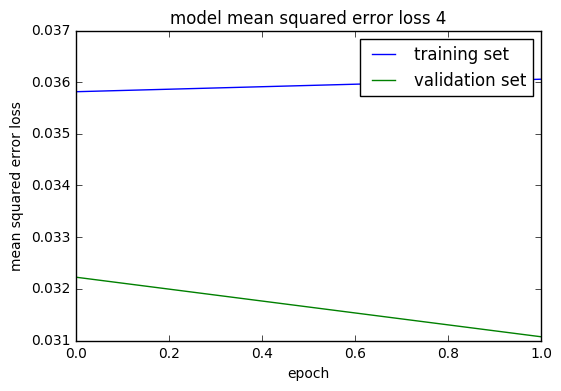

model_4.json and model_4.h5 have been saved successfully


In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import Input, ELU
import pydot

from keras.utils.visualize_util import plot


def get_NVIDIA_model(): #https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
    input_shape = (66, 200,3)
    filter_size = 3
    pool_size = (2,2)
    model = Sequential()
    model.add(Lambda(lambda x: x/255.-0.5,input_shape=input_shape))
    model.add(Convolution2D(24,5, 5, subsample=(2, 2),init='he_normal',border_mode='valid'))
    model.add(ELU())
    model.add(Convolution2D(36,5, 5, subsample=(2, 2),init='he_normal',border_mode='valid'))
    model.add(ELU())
    model.add(Convolution2D(48,5, 5,  subsample=(2, 2),init='he_normal',border_mode='valid'))
    model.add(ELU())
    model.add(Convolution2D(64,3, 3, subsample=(1, 1), init='he_normal',border_mode='valid'))
    model.add(ELU())
    model.add(Convolution2D(64,3, 3, subsample=(1, 1), init='he_normal',border_mode='valid'))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(1164, init='he_normal'))
    model.add(ELU())
    model.add(Dense(100, init='he_normal'))
    model.add(ELU())
    model.add(Dense(50, init='he_normal'))
    model.add(ELU())
    model.add(Dense(10,init='he_normal'))
    model.add(ELU())
    model.add(Dropout (0.5))
    model.add(Dense(1, init='he_normal'))
       
    return model 

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model =get_NVIDIA_model()
model.compile(optimizer=adam,loss='mse')

plot(model, to_file='model.png')

sample_size = len(driving_log['center'] )*2
epoch_size = sample_size*8
for index in range(5):
    history = model.fit_generator(train_data_generator, validation_data = validation_data_generator,samples_per_epoch = epoch_size, nb_val_samples = sample_size, nb_epoch=2) 
    json_file = 'model_' + str(index) + '.json'
    weights_file = 'model_' + str(index) + '.h5'
    
    ### plot the training and validation loss for each epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model mean squared error loss ' + str(index))
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

    save_model(json_file,weights_file )

0.0429010755917
0.01733473315834999
0.0596424180033
0.015077359974384308
0.594790706377
-0.000764473807066679


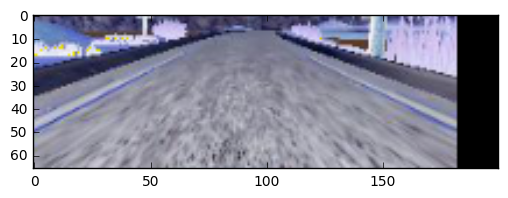

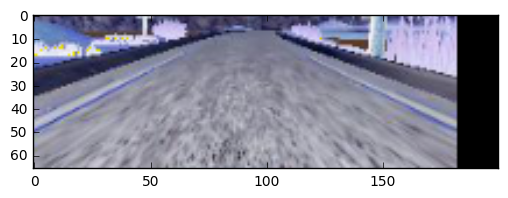

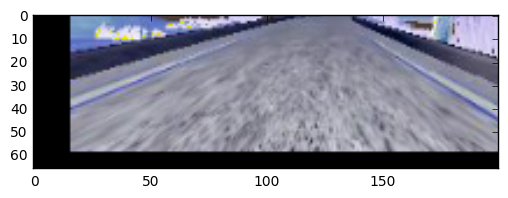

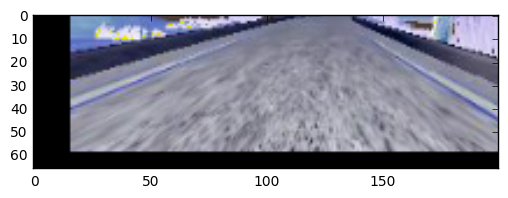

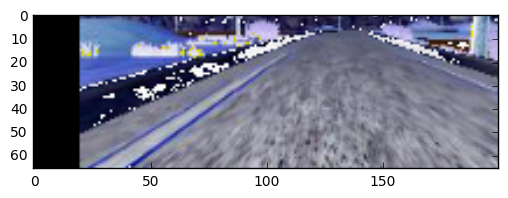

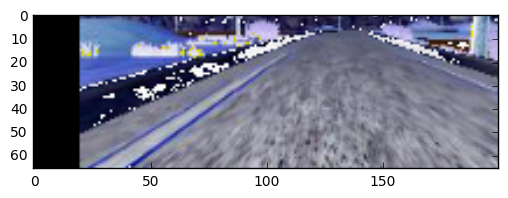

In [9]:
plot(model, to_file='model.png',show_shapes =True, show_layer_names=False)

from keras.models import model_from_json
from keras.preprocessing.image import img_to_array

def AOI_image1 (img, resize_value):
    #Area of interest of the image, it applies crop and resize.
    nimg = cv2.resize(img,resize_value)
    return nimg

def preprocess_input(img):
    return AOI_image1 (img,(200,66))

with open('model_0.json') as json_data:
    model = model_from_json(json_data.read())
#model =get_NVIDIA_model()
model.compile("adam", "mse")
weights_file = 'model_0.h5'

for i in range(3):
    ximage, ysteering = preprocess_image(d_line,(200,66))
    plt.figure()
    plt.imshow(ximage)
    print(ysteering)
    #x = np.asarray(ximage, dtype=np.float32)
    image_array = ximage
    plt.figure()
    plt.imshow(image_array )
    transformed_image_array = image_array[None, :, :, :]
    steering_angle = float(model.predict(transformed_image_array, batch_size=1))
    print (steering_angle)



